In [8]:
import openseespy.opensees as op
import numpy as np
import opsvis as ovs
import matplotlib.pyplot as plt

In [13]:
# =============================================================================
# Material properties
# =============================================================================

#Confined Concrete
fpc= -6.0  #Compressive Strength
epsc0= -0.004 #Concrete Strain at maximum strength
fpcu= -5.0 #Crushing Strength
epsu= -0.014#Strain at crushing Strength


#UnConfined Concrete
fpc1= -5.0
epsc01=-0.002
fpcu1=0.0
epsu1=-0.006


#Steel
fy=  60.0#yield strength
E0= 30000#initial elastic tangent
b= 0.01#strain-hardening ratio

# =============================================================================
# Section Size
# =============================================================================
h = 24 #Section Depth
w = 15 #Section Width
cov = 1.5  #Effective Cover
A_steel= 0.6
op.wipe()

In [14]:
def buildSections():
    op.model('basic','-ndm',2,'-ndf',3)
    
    #uniaxialMaterial('Concrete01', matTag, fpc, epsc0, fpcu, epsU)
    op.uniaxialMaterial('Concrete01', 1, fpc, epsc0, fpcu, epsu)  #COnfined Cocnrete
    op.uniaxialMaterial('Concrete01', 2, fpc1, epsc01, fpcu1, epsu1)  #Unonfined COncrete
   
    #uniaxialMaterial('Steel01', matTag, Fy, E0, b, a1, a2, a3, a4)
    op.uniaxialMaterial('Steel01', 3, fy, E0,b)
    
    op.section('Fiber', 1)
    ydiv=10
    zdiv=1

    ydiv=10
    zdiv=1
    vertices_core=np.array([cov-h/2,w/2-cov,h/2-cov,cov-w/2])
    vertices_top=np.array([h/2-cov,w/2-cov,h/2,cov-w/2])
    vertices_bot=np.array([-h/2,w/2-cov,cov-h/2,cov-w/2])
    vertices_left=np.array([-h/2,w/2,h/2,w/2-cov])
    vertices_right=np.array([-h/2,cov-w/2,h/2,-w/2])

    # Creating concrete  fiber
    #patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)
    op.patch('rect', 1,ydiv, zdiv, *vertices_core) #inner concrete
    op.patch('rect', 2,2,1, *vertices_top) #top concrete
    op.patch('rect', 2,2,1, *vertices_bot) #bottom concrete
    op.patch('rect', 2,ydiv, zdiv, *vertices_left) #left concrete
    op.patch('rect', 2,ydiv, zdiv, *vertices_right) #right concrete
    
    #creating layer of steel fibers
    #layer('straight', matTag, numFiber, areaFiber, *start, *end)
    op.layer('straight', 3, 3, A_steel, *[h/2-cov, w/2-cov],*[cov-h/2,w/2-cov])
    op.layer('straight', 3, 2, A_steel, *[h/2-cov, 0],*[cov-h/2,0])
    op.layer('straight', 3, 3, A_steel, *[h/2-cov, cov-w/2],*[cov-h/2,cov-w/2])
     

    fibsec=[['section','Fiber',1],
            ['patch', 'rect',1,10, 1, *vertices_core],
            ['patch', 'rect',2,2,1, *vertices_top],
            ['patch', 'rect',2,2,1, *vertices_bot],
            ['patch', 'rect',2,10,1, *vertices_left],
            ['patch', 'rect',2,10,1, *vertices_right],
            ['layer', 'straight', 3, 3, A_steel, *[h/2-cov, w/2-cov],*[cov-h/2,w/2-cov] ],
            ['layer', 'straight', 3, 2, A_steel, *[h/2-cov, 0],*[cov-h/2,0] ],
            ['layer', 'straight', 3, 3, A_steel, *[h/2-cov, cov-w/2],*[cov-h/2,cov-w/2]]
            ]

    ovs.plot_fiber_section(fibsec)
    plt.title('Fiber Section of Zero Length Element')
    plt.axis('equal')
    plt.show()

In [15]:
def MomentCurvature(sectag, Axial_load, maxK, numIncr):
    
    #Define two nodes:
    op.node(1,0.0,0.0)
    op.node(2,0.0,0.0)
    
    #Define Boundary Condition
    op.fix(1,1,1,1)  # Node 1 completely fixed
    op.fix(2,0,1,0)  # Node 2 fixed in y dir, as axial load in x-dir and moment about z-dir
    
    #Define Zero length section element
    #element('zeroLengthSection', eleTag, *eleNodes, secTag)
    op.element('zeroLengthSection',1,*[1,2],1)
    
    #Create recorder
    op.recorder('Node','-file',f'section{sectag}.out','-time','-node',2,'-dof',3,'disp')
    
    #define constant axial load
    #timeSeries('Constant', tag)
    op.timeSeries('Constant',1)
    op.timeSeries("Linear",2)
    
    #pattern('Plain', patternTag, tsTag)
    op.pattern('Plain',1,1)
    
    #load(nodeTag, *loadValues)
    op.load(2,Axial_load,0.,0.)
    
    #Define ANalysis Options
    # create SOE
    op.system("SparseGeneral","-piv")
    # create DOF number
    op.numberer("Plain")
    # create constraint handler
    op.constraints("Plain")
    # create integrator
    op.integrator("LoadControl", 0.0)
    # create algorithm
    op.algorithm("Newton")
    # create analysis object
    op.analysis("Static")
    
    #create test
    op.test('NormUnbalance', 1.*10**-9, 10)
    
    #Perform one analysis for constant axial laod
    op.analyze(1)
    
    #Define reference moment
    op.pattern('Plain',2,2)
    op.load(2,0.0,0.0,1.0)
    
    #Compute curvature increment
    dK = maxK/numIncr
    ControlNode = 2
    dof = 3 #Moment controling about Z-direction
    
    #integrator('DisplacementControl', nodeTag, dof, incr)
    op.integrator('DisplacementControl', ControlNode, dof, dK)
     
    op.analyze(numIncr)

op.wipe()
#Estimate Yield Curvature
eff_depth = h - cov  # Cover to rebar --> Effective depth
epsy = fy/E0  #steel yield strain
Ky = epsy/(0.7*eff_depth)

#Set the desired axialload and Moment
Pu = -180 #Compressive Axial load
Mu = 15   # Moment about Z-axis
numIncr = 100

maxK = Ky * Mu


Warning! Patch quad is non-convex or counter-clockwise defined or has at least 3 colinear points in line

Warning! Patch quad is non-convex or counter-clockwise defined or has at least 3 colinear points in line

Warning! Patch quad is non-convex or counter-clockwise defined or has at least 3 colinear points in line

Warning! Patch quad is non-convex or counter-clockwise defined or has at least 3 colinear points in line

Warning! Patch quad is non-convex or counter-clockwise defined or has at least 3 colinear points in line


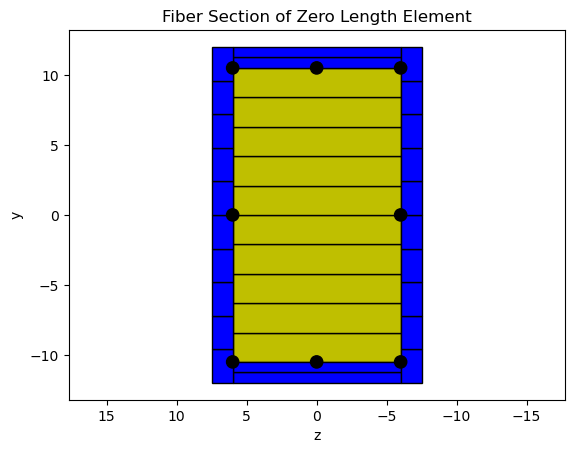

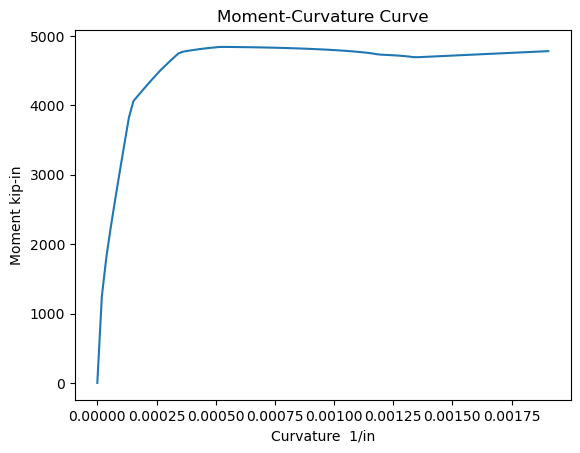

In [16]:
# =============================================================================
# Analysing
# =============================================================================
buildSections()
MomentCurvature(1, Pu, maxK, numIncr)
op.wipe()  
    
outputs = np.loadtxt("section1.out",delimiter=' ')
x_data = outputs[:,1]
y_data = outputs[:,0]
plt.plot(x_data, y_data)
plt.xlabel("Curvature  1/in")
plt.ylabel("Moment kip-in")
plt.title("Moment-Curvature Curve")
plt.show()